## Specific humidity (hus) - one model
With this variable we can identify drying in different parts of the atmosphere

In [1]:
import xarray as xr
import numpy as np
import skimage.measure as skm
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from os.path import expanduser
home = expanduser("~")

import timeit

In [2]:
models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]
model = models[0]


experiments = [
    'historical',
    #'rcp85'
    ]
experiment = experiments[0]       

In [3]:
folder = home + '/Documents/data/cmip5/' + 'ds'
fileName = model + '_hus_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
hus = ds.hus

In [4]:
hus

<xarray.DataArray 'hus' (time: 10950, plev: 8, lat: 22, lon: 128)>
[246681600 values with dtype=float32]
Coordinates:
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2

In [5]:
pw = xr.DataArray(
    data=-scipy.integrate.simpson(hus.fillna(0), hus.plev.data, axis=1, even='last'),
    dims=['time','lat', 'lon'],
    coords={'time': hus.time.data, 'lat': hus.lat.data, 'lon': hus.lon.data},
    attrs={'units':'mm/day',
            'Description': 'precipitable water'}
    )

In [6]:
hus['plev']

<xarray.DataArray 'plev' (plev: 8)>
array([100000.,  85000.,  70000.,  50000.,  25000.,  10000.,   5000.,   1000.])
Coordinates:
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03

In [7]:
da = hus.sel(plev = slice(1000e2, 500e2))
pw_lower = xr.DataArray(
    data=-scipy.integrate.simpson(da.fillna(0), da.plev.data, axis=1, even='last'),
    dims=['time','lat', 'lon'],
    coords={'time': da.time.data, 'lat': da.lat.data, 'lon': da.lon.data},
    attrs={'units':'mm/day',
            'Description': 'precipitable water'}
    )

In [8]:
da = hus.sel(plev = slice(500e2, 10e2))
pw_upper = xr.DataArray(
    data=-scipy.integrate.simpson(da.fillna(0), da.plev.data, axis=1, even='last'),
    dims=['time','lat', 'lon'],
    coords={'time': da.time.data, 'lat': da.lat.data, 'lon': da.lon.data},
    attrs={'units':'mm/day',
            'Description': 'precipitable water'}
    )

In [9]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

def plot_snapshot(var, cmap, variable_name, model):
    projection = ccrs.PlateCarree(central_longitude=180)
    lat = var.lat
    lon = var.lon

    f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(15, 5))

    var.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055}, cmap=cmap)
    ax.add_feature(cfeat.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.set_title(variable_name + ' snapshot, model:' + model)
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])
    ax.set_yticks([-20, 0, 20])
    plt.tight_layout()

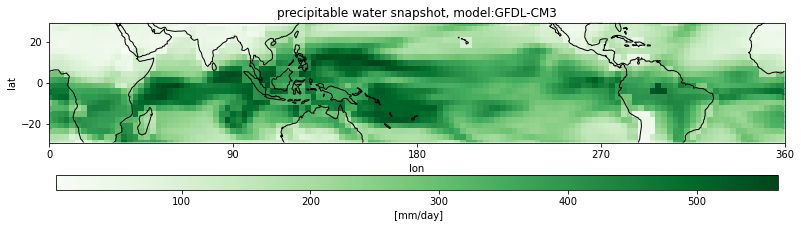

In [10]:
plot_snapshot(pw.isel(time=0), 'Greens', 'precipitable water', model)

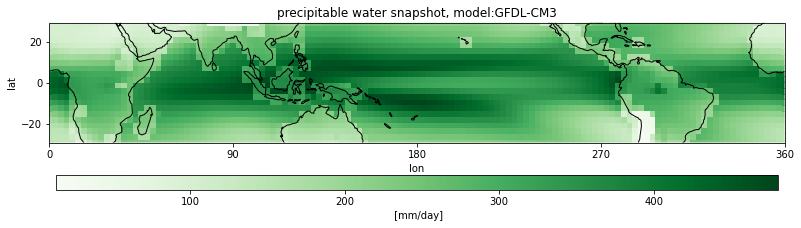

In [11]:
plot_snapshot(pw.mean(dim = 'time', keep_attrs=True), 'Greens', 'precipitable water', model)

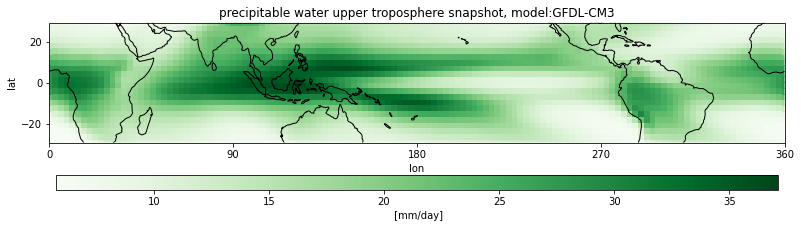

In [12]:
plot_snapshot(pw_upper.mean(dim = 'time', keep_attrs=True), 'Greens', 'precipitable water upper troposphere', model)

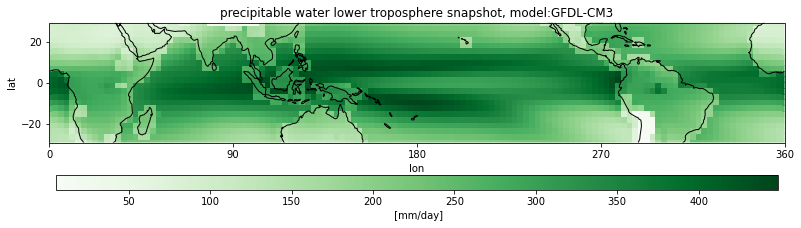

In [13]:
plot_snapshot(pw_lower.mean(dim = 'time', keep_attrs=True), 'Greens', 'precipitable water lower troposphere', model)

In [14]:
aWeights = np.cos(np.deg2rad(hus.lat))

Text(0, 0.5, 'precipitable water [mm/day]')

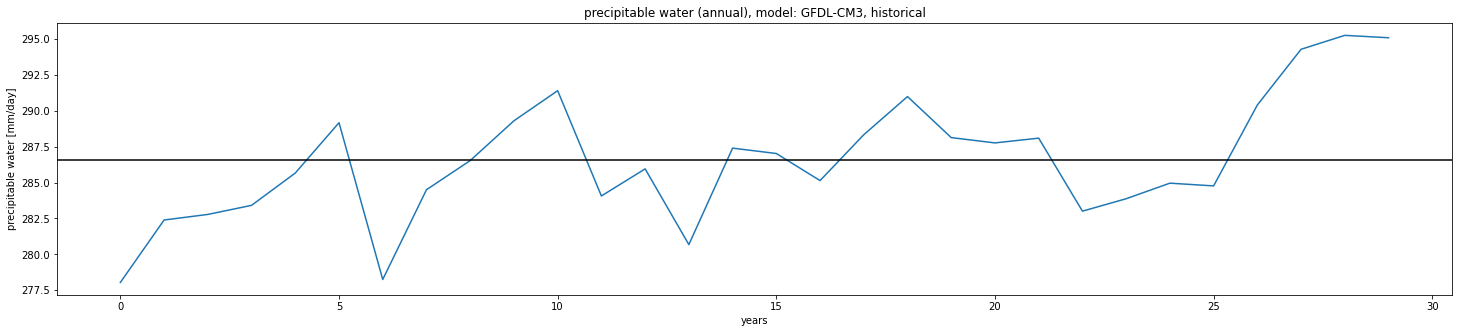

In [15]:
f, ax = plt.subplots(figsize = (25,5))
ax.plot(pw.resample(time='Y').mean(dim='time').weighted(aWeights).mean(dim=('lat','lon')))
ax.axhline(y=pw.weighted(aWeights).mean(dim=('lat','lon')).mean(dim='time'), color='k')
ax.set_title('precipitable water (annual), model: ' + model + ', ' + experiment)
ax.set_xlabel('years')
ax.set_ylabel('precipitable water [mm/day]')

Text(0, 0.5, 'precipitable water [mm/day]')

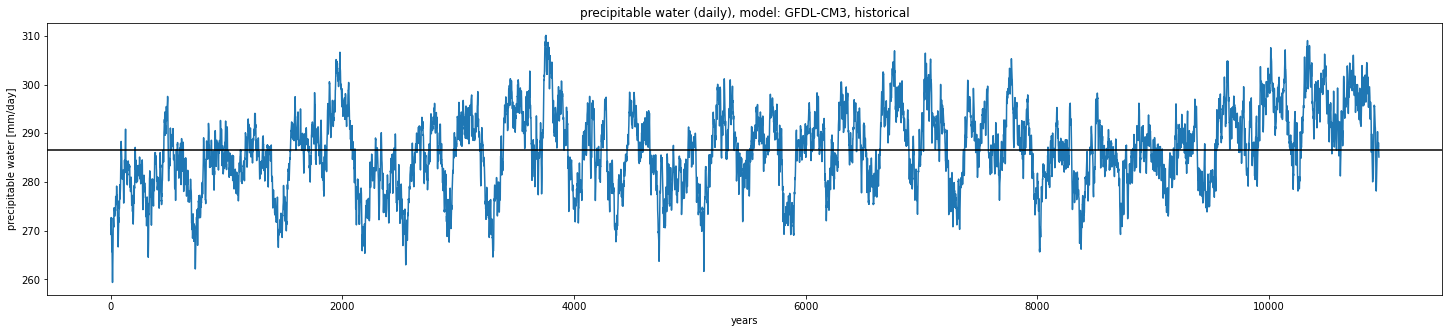

In [16]:
f, ax = plt.subplots(figsize = (25,5))
ax.plot(pw.weighted(aWeights).mean(dim=('lat','lon')))
ax.axhline(y=pw.weighted(aWeights).mean(dim=('lat','lon')).mean(dim='time'), color='k')
ax.set_title('precipitable water (daily), model: ' + model + ', ' + experiment)
ax.set_xlabel('years')
ax.set_ylabel('precipitable water [mm/day]')

Text(-375, 475, 'tMean Specific humidity at different pressure levels historical')

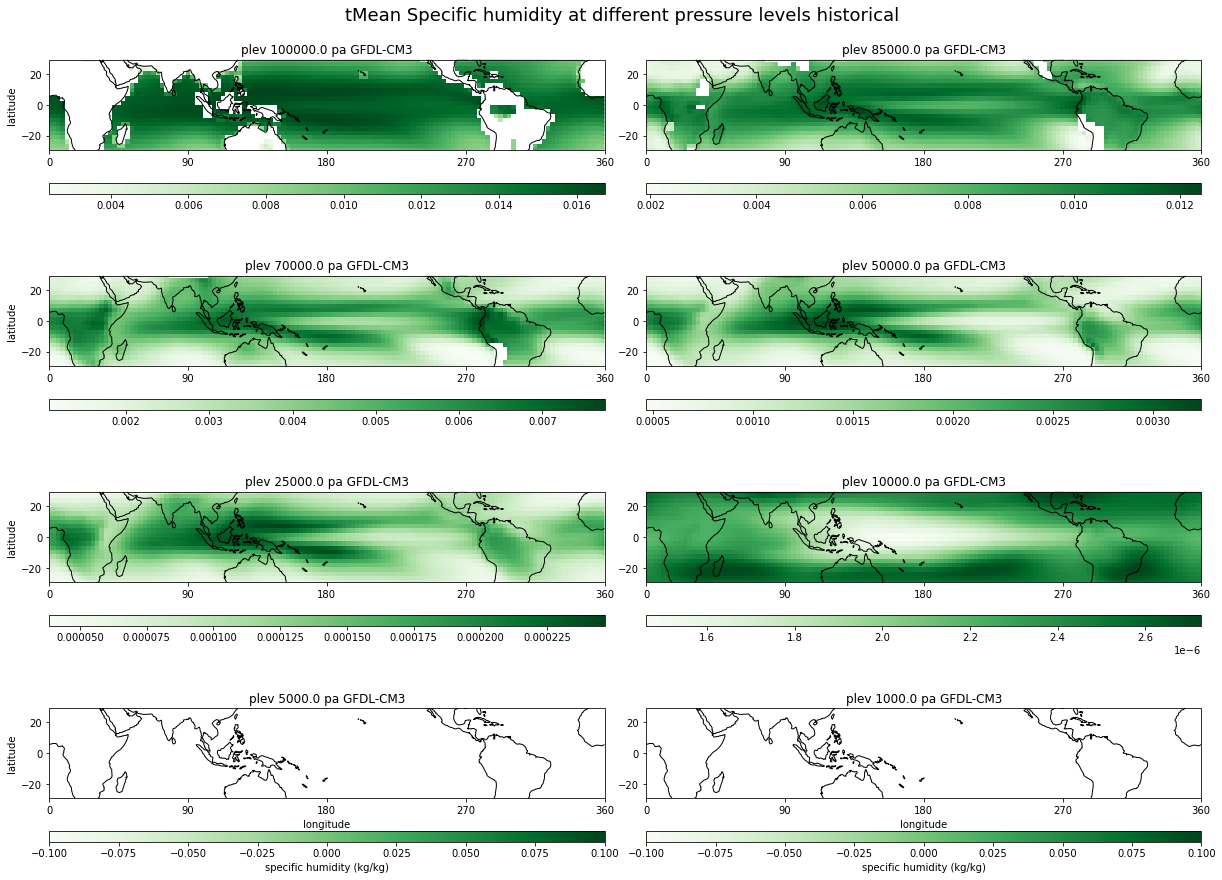

In [17]:
plevs = hus['plev']
lat = hus.lat
lon = hus.lon
lonm,latm = np.meshgrid(lon,lat)

fig, axs = plt.subplots(4, 2, figsize=(20, 15),
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

 
for ax, plev in zip(axs.flat, plevs):

    pcm= ax.pcolormesh(lonm,latm, hus.mean(dim='time').sel(plev = plev),transform=ccrs.PlateCarree(),zorder=0, cmap='Greens') #,vmin=0,vmax=12)
    ax.add_feature(cfeat.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.set_title('plev ' + str(plev.data) + ' pa ' + model)

    if plev <= 5000:
        ax.set_xlabel('longitude')
        plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.15, aspect=50, fraction=0.055, label = 'specific humidity (kg/kg)')
    else:
        plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.15, aspect=50, fraction=0.055)

    if plev == 100000 or plev ==70000 or plev == 25000 or plev ==5000:
        ax.set_ylabel('latitude')

    ax.set_yticks([-20, 0, 20])
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])



plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.90, wspace=0.075, hspace=0.001)
plt.text(-375,475, 'tMean Specific humidity at different pressure levels ' + experiment,fontsize=18)


[Text(0, 0, '100000.0'),
 Text(1, 0, '85000.0'),
 Text(2, 0, '70000.0'),
 Text(3, 0, '50000.0'),
 Text(4, 0, '25000.0'),
 Text(5, 0, '10000.0'),
 Text(6, 0, '5000.0'),
 Text(7, 0, '1000.0')]

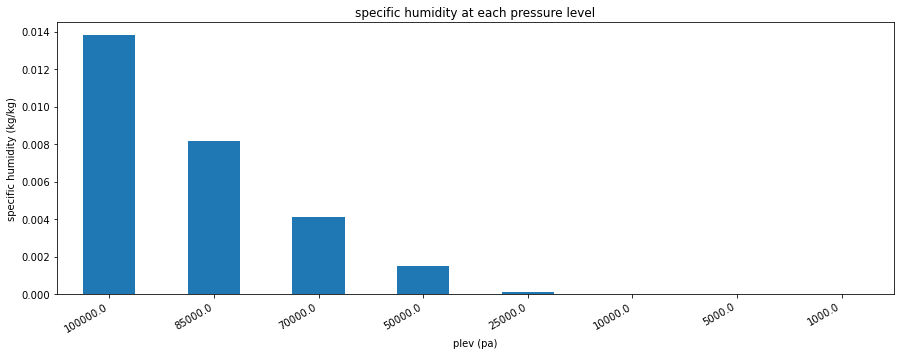

In [18]:
fig, ax = plt.subplots(figsize = (15,5))
hus.weighted(aWeights).mean(dim=('lat', 'lon')).mean(dim='time').to_series().plot.bar(ax=ax)
ax.set_title('specific humidity at each pressure level')
ax.set_xlabel("plev (pa)")
ax.set_ylabel("specific humidity (kg/kg)")
ax.set_xticklabels(hus['plev'].data, rotation=30, ha='right')


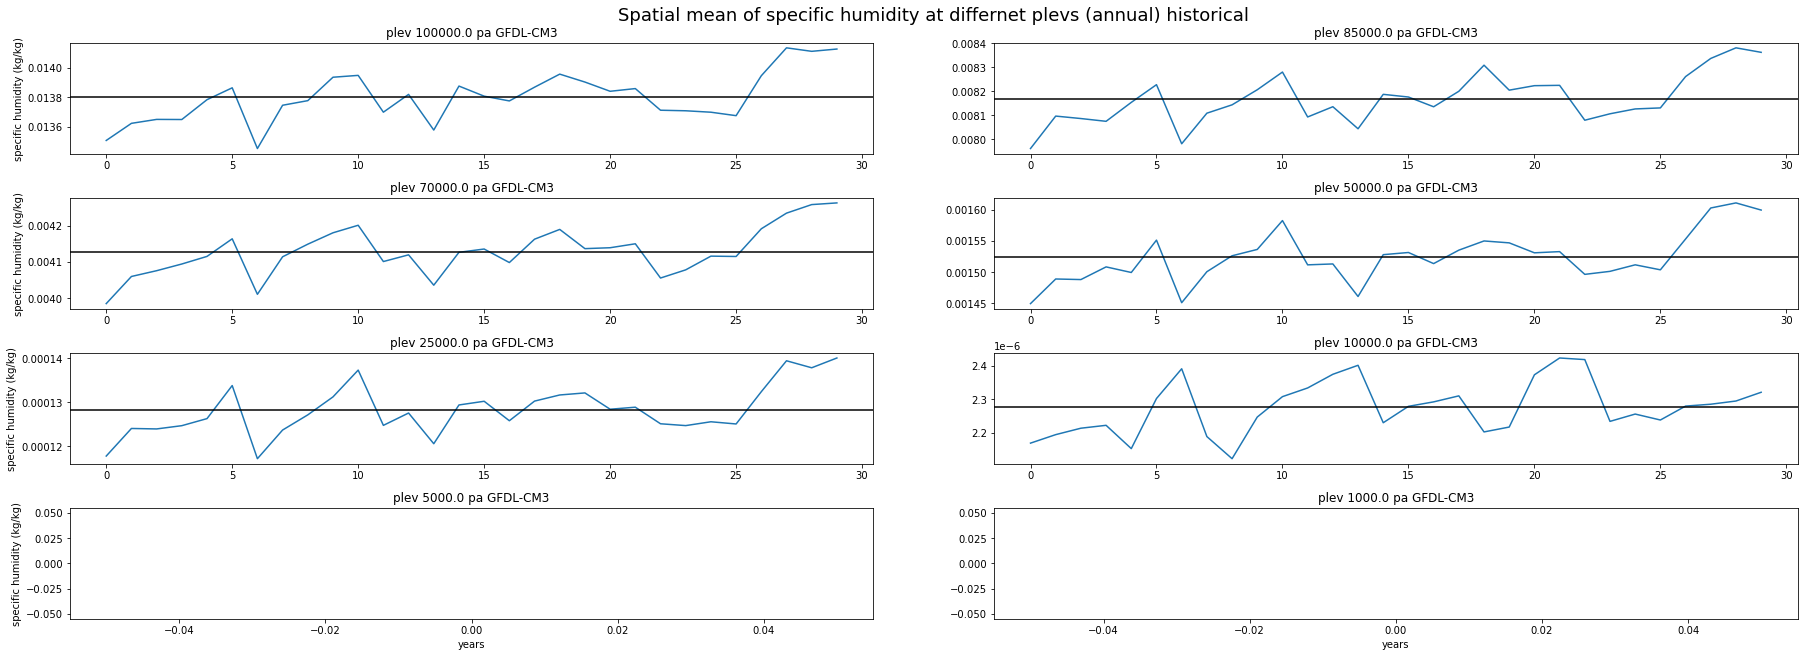

In [19]:
f, axes = plt.subplots(nrows=4, ncols=2, figsize = (30,10))
f.suptitle('Spatial mean of specific humidity at differnet plevs (annual) ' + experiment, fontsize=18, y=0.95)

plevs = hus['plev']

for ax, plev in zip(axes.flat, plevs):

    ax.plot(hus.weighted(aWeights).mean(dim=('lat', 'lon')).sel(plev = plev).resample(time='Y').mean(dim='time'))
    ax.axhline(y=hus.weighted(aWeights).mean(dim=('lat', 'lon')).sel(plev = plev).mean(dim='time'), color='k')
    ax.set_title('plev ' + str(plev.data) + ' pa ' + model)


    if plev <= 5000:
        ax.set_xlabel('years')

    if plev == 100000 or plev ==70000 or plev == 25000 or plev ==5000:
        ax.set_ylabel('specific humidity (kg/kg)')


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.4)

In [20]:
def to_monthly(da):
    year = da.time.dt.year
    month = da.time.dt.month

    # assign new coords
    da = da.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return da.set_index(time=("year", "month")).unstack("time")

In [21]:
hus_season = hus.weighted(aWeights).mean(dim=('lat', 'lon')).resample(time='QS-DEC').mean(dim="time")
hus_season = to_monthly(hus_season)
hus_season = hus_season.rename({'month':'season'})
hus_season = hus_season.assign_coords(season = ["MAM", "JJA", "SON", "DJF"])

In [22]:
print(hus_season.season.values)

['MAM' 'JJA' 'SON' 'DJF']


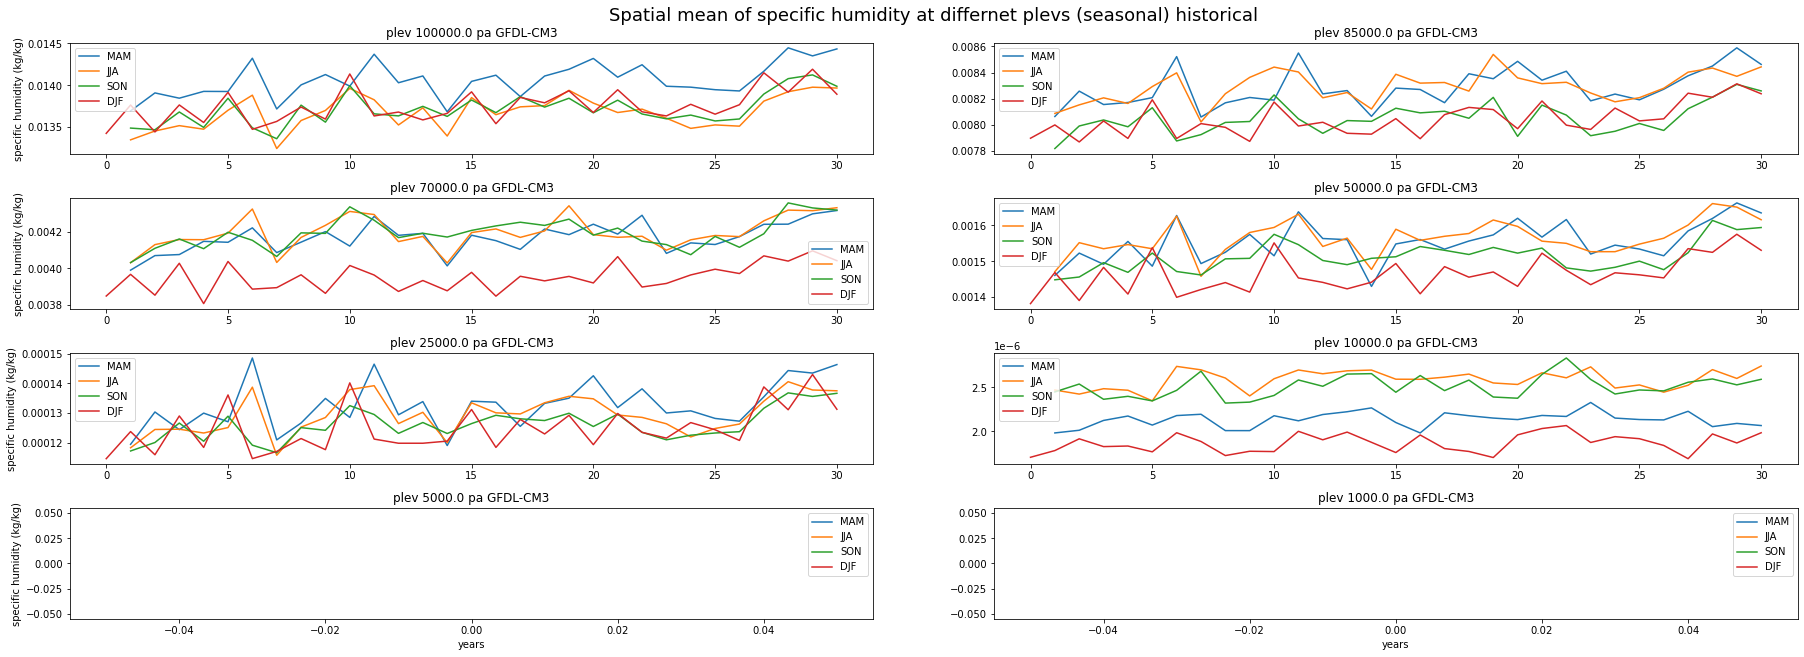

In [23]:
f, axes = plt.subplots(nrows=4, ncols=2, figsize = (30,10))
f.suptitle('Spatial mean of specific humidity at differnet plevs (seasonal) ' + experiment, fontsize=18, y=0.95)

plevs = hus['plev']

for ax, plev in zip(axes.flat, plevs):

    ax.plot(hus_season.sel(plev = plev), label = hus_season.season.values)
    ax.set_title('plev ' + str(plev.data) + ' pa ' + model)
    ax.legend()

    if plev <= 5000:
        ax.set_xlabel('years')

    if plev == 100000 or plev ==70000 or plev == 25000 or plev ==5000:
        ax.set_ylabel('specific humidity (kg/kg)')


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.4)

In [24]:
hus_monthly = to_monthly(hus.weighted(aWeights).mean(dim=('lat', 'lon')))
hus_monthly = hus_monthly.assign_coords(month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul','aug', 'sep', 'oct', 'nov', 'dec'])

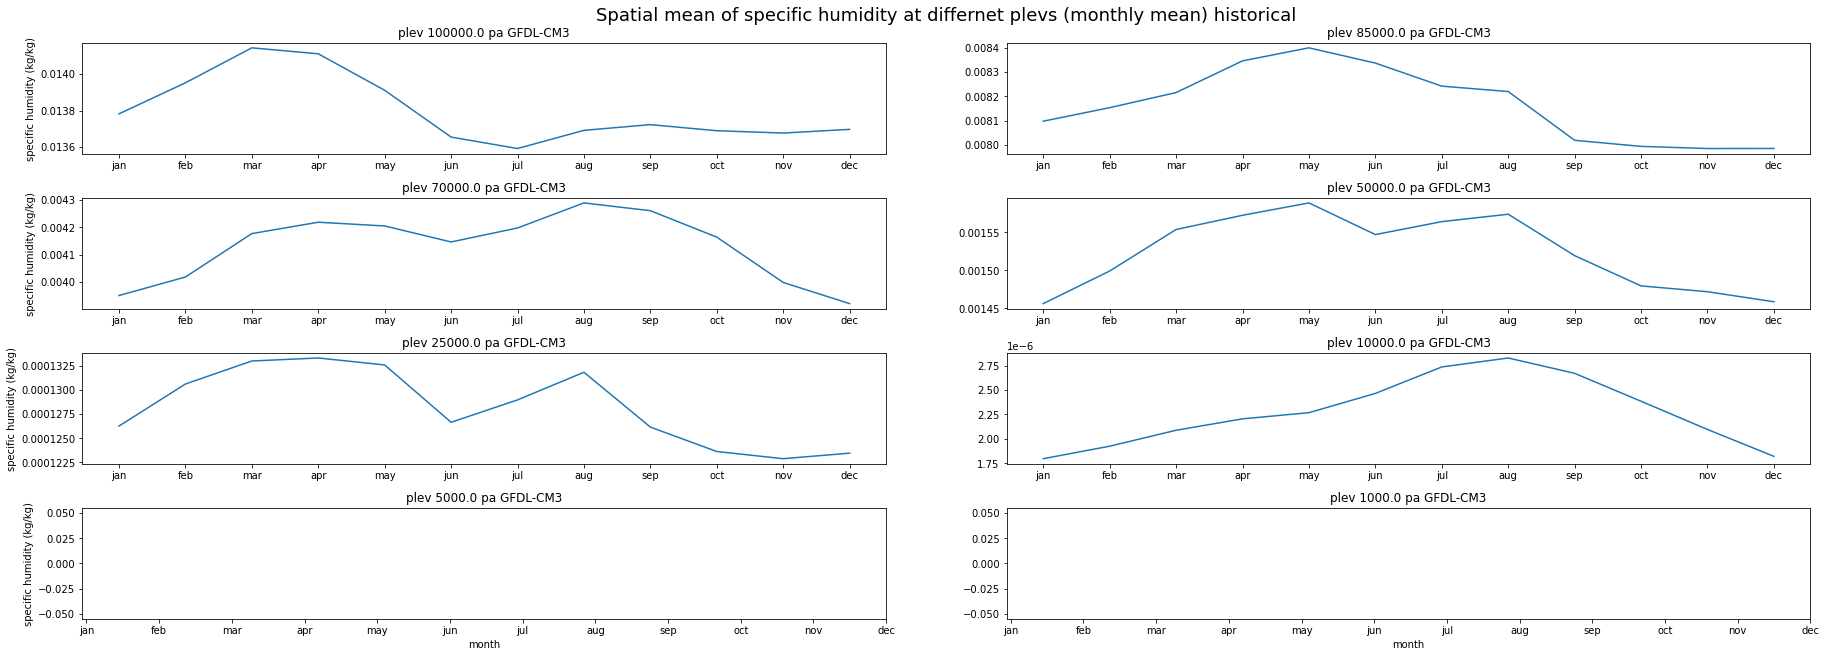

In [25]:
f, axes = plt.subplots(nrows=4, ncols=2, figsize = (30,10))
f.suptitle('Spatial mean of specific humidity at differnet plevs (monthly mean) ' + experiment, fontsize=18, y=0.95)

plevs = hus['plev']

for ax, plev in zip(axes.flat, plevs):

    ax.plot(hus_monthly.sel(plev = plev).mean(dim='year'))
    ax.set_title('plev ' + str(plev.data) + ' pa ' + model)
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(hus_monthly.month.values)

    if plev <= 5000:
        ax.set_xlabel('month')

    if plev == 100000 or plev ==70000 or plev == 25000 or plev ==5000:
        ax.set_ylabel('specific humidity (kg/kg)')


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.4)

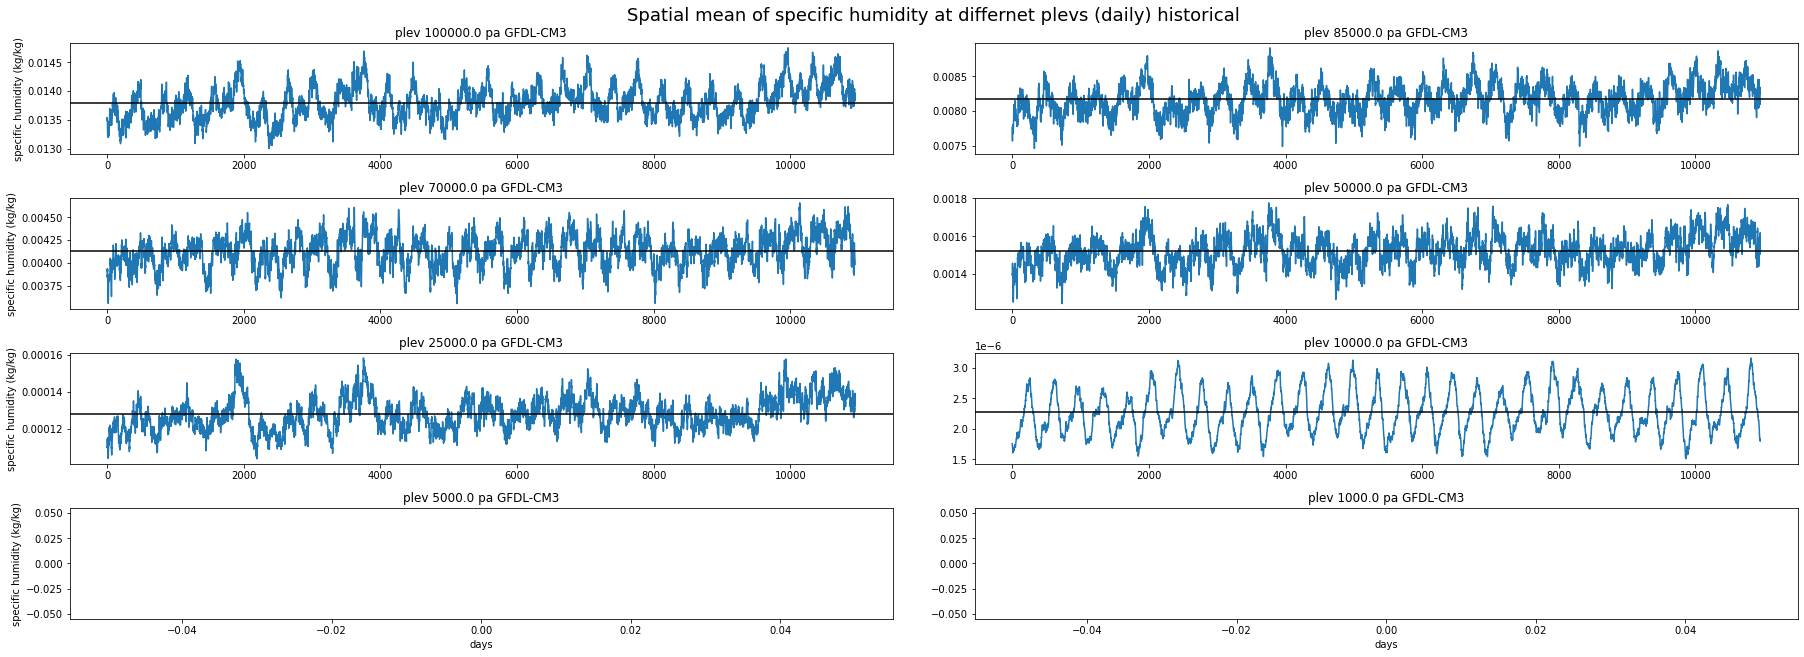

In [26]:
f, axes = plt.subplots(nrows=4, ncols=2, figsize = (30,10))
f.suptitle('Spatial mean of specific humidity at differnet plevs (daily) ' + experiment, fontsize=18, y=0.95)

plevs = hus['plev']

for ax, plev in zip(axes.flat, plevs):

    ax.plot(hus.weighted(aWeights).mean(dim=('lat', 'lon')).sel(plev = plev))
    ax.axhline(y=hus.weighted(aWeights).mean(dim=('lat', 'lon')).sel(plev = plev).mean(dim='time'), color='k')
    ax.set_title('plev ' + str(plev.data) + ' pa ' + model)
    #ax.set_ylim(0,0.015)

    if plev <= 5000:
        ax.set_xlabel('days')

    if plev == 100000 or plev ==70000 or plev == 25000 or plev ==5000:
        ax.set_ylabel('specific humidity (kg/kg)')


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.4)

### from difference between scenarios

In [27]:
folder = home + '/Documents/data/cmip5/' + 'ds'
fileName = model + '_hus_historical.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
hus_historical = ds.hus #.fillna(0)


folder = home + '/Documents/data/cmip5/' + 'ds'
fileName = model + '_hus_rcp85.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
hus_rcp = ds.hus #.fillna(0)

In [28]:
hus_diff = xr.DataArray(
        data=hus_rcp.values - hus_historical.values,
        dims=['time','plev','lat', 'lon'],
        coords={'time': hus.time.data, 'plev': hus.plev.data, 'lat': hus.lat.data, 'lon': hus.lon.data},
        attrs={'units':'kg/kg'}
        )

In [29]:
np.nanmax(hus_diff.values)

0.020420501

/var/folders/w4/tbqrrpzx0bd8qgzdjj9dzv2dhl9fz3/T/ipykernel_56143/645158484.py:12: RuntimeWarning: All-NaN slice encountered
  pcm= ax.pcolormesh(lonm,latm, hus_diff.mean(dim='time').sel(plev = plev),transform=ccrs.PlateCarree(),zorder=0, cmap="RdBu", vmin=-np.nanmax(hus_diff.mean(dim='time').sel(plev = plev).values), vmax=np.nanmax(hus_diff.mean(dim='time').sel(plev = plev).values)) #,vmin=0,vmax=12)
/var/folders/w4/tbqrrpzx0bd8qgzdjj9dzv2dhl9fz3/T/ipykernel_56143/645158484.py:12: RuntimeWarning: All-NaN slice encountered
  pcm= ax.pcolormesh(lonm,latm, hus_diff.mean(dim='time').sel(plev = plev),transform=ccrs.PlateCarree(),zorder=0, cmap="RdBu", vmin=-np.nanmax(hus_diff.mean(dim='time').sel(plev = plev).values), vmax=np.nanmax(hus_diff.mean(dim='time').sel(plev = plev).values)) #,vmin=0,vmax=12)
/var/folders/w4/tbqrrpzx0bd8qgzdjj9dzv2dhl9fz3/T/ipykernel_56143/645158484.py:12: RuntimeWarning: All-NaN slice encountered
  pcm= ax.pcolormesh(lonm,latm, hus_diff.mean(dim='time').sel(plev =

Text(-375, 475, 'Moistening with warming at different pressure levels historical')

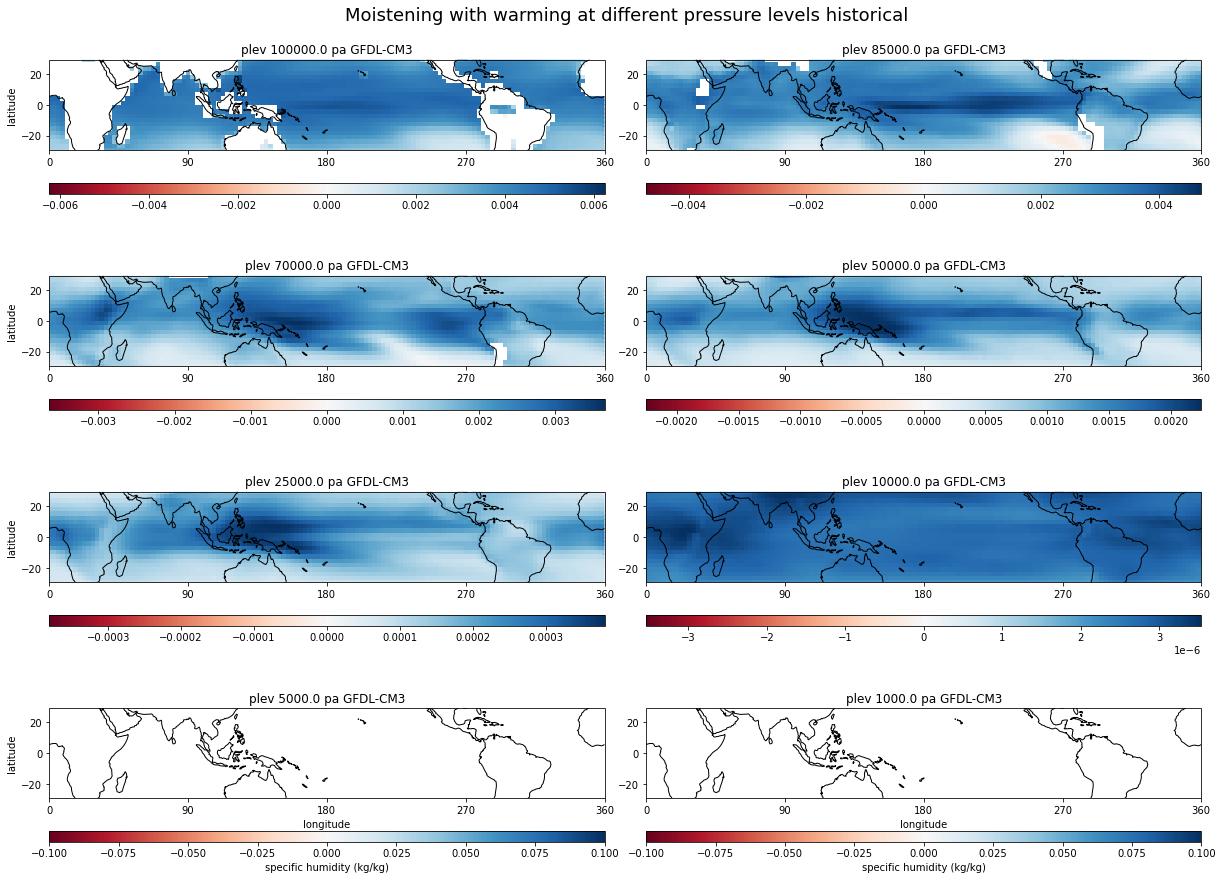

In [30]:
plevs = hus['plev']
lat = hus.lat
lon = hus.lon
lonm,latm = np.meshgrid(lon,lat)

fig, axs = plt.subplots(4, 2, figsize=(20, 15),
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

 
for ax, plev in zip(axs.flat, plevs):

    pcm= ax.pcolormesh(lonm,latm, hus_diff.mean(dim='time').sel(plev = plev),transform=ccrs.PlateCarree(),zorder=0, cmap="RdBu", vmin=-np.nanmax(hus_diff.mean(dim='time').sel(plev = plev).values), vmax=np.nanmax(hus_diff.mean(dim='time').sel(plev = plev).values)) #,vmin=0,vmax=12)
    ax.add_feature(cfeat.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.set_title('plev ' + str(plev.data) + ' pa ' + model)

    if plev <= 5000:
        ax.set_xlabel('longitude')
        plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.15, aspect=50, fraction=0.055, label = 'specific humidity (kg/kg)')
    else:
        plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.15, aspect=50, fraction=0.055)

    if plev == 100000 or plev ==70000 or plev == 25000 or plev ==5000:
        ax.set_ylabel('latitude')

    ax.set_yticks([-20, 0, 20])
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])



plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.90, wspace=0.075, hspace=0.001)
plt.text(-375,475, 'Moistening with warming at different pressure levels ' + experiment,fontsize=18)


[Text(0, 0, '100000.0'),
 Text(1, 0, '85000.0'),
 Text(2, 0, '70000.0'),
 Text(3, 0, '50000.0'),
 Text(4, 0, '25000.0'),
 Text(5, 0, '10000.0'),
 Text(6, 0, '5000.0'),
 Text(7, 0, '1000.0')]

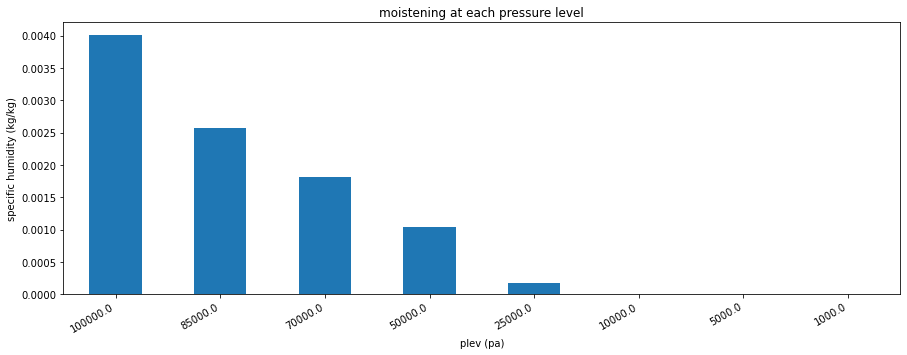

In [31]:
fig, ax = plt.subplots(figsize = (15,5))
hus_diff.weighted(aWeights).mean(dim=('lat', 'lon')).mean(dim='time').to_series().plot.bar(ax=ax)
ax.set_title('moistening at each pressure level')
ax.set_xlabel("plev (pa)")
ax.set_ylabel("specific humidity (kg/kg)")
ax.set_xticklabels(hus['plev'].data, rotation=30, ha='right')

In [32]:
folder = home + '/Documents/data/cmip5/' + model
fileName = model + '_rome_' + experiment + '.nc'
path = folder + '/' + fileName
rome = xr.open_dataset(path)
rome

<xarray.Dataset>
Dimensions:  (time: 10950)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Data variables:
    rome     (time) float64 ...
    rome_n   (time) float64 ...
Attributes:
    description:  ROME based on all and the 8 largest contiguous convective r...
    units:        km^2

In [33]:
rome_options = [
    'rome',
    # 'rome_n'
    ]
rome_option = rome_options[0]

In [34]:
pw = xr.DataArray(
    data=-scipy.integrate.simpson(hus.fillna(0), hus.plev.data, axis=1, even='last'),
    dims=['time','lat', 'lon'],
    coords={'time': hus.time.data, 'lat': hus.lat.data, 'lon': hus.lon.data},
    attrs={'units':'mm/day',
            'Description': 'precipitable water'}
    )

da = hus.sel(plev = slice(1000e2, 500e2))
pw_lower = xr.DataArray(
    data=-scipy.integrate.simpson(da.fillna(0), da.plev.data, axis=1, even='last'),
    dims=['time','lat', 'lon'],
    coords={'time': da.time.data, 'lat': da.lat.data, 'lon': da.lon.data},
    attrs={'units':'mm/day',
            'Description': 'precipitable water'}
    )

da = hus.sel(plev = slice(500e2, 10e2))
pw_upper = xr.DataArray(
    data=-scipy.integrate.simpson(da.fillna(0), da.plev.data, axis=1, even='last'),
    dims=['time','lat', 'lon'],
    coords={'time': da.time.data, 'lat': da.lat.data, 'lon': da.lon.data},
    attrs={'units':'mm/day',
            'Description': 'precipitable water'}
    )

In [35]:
pw

<xarray.DataArray (time: 10950, lat: 22, lon: 128)>
array([[[169.32228825, 157.93009405, 144.80758007, ..., 210.84788834,
         195.56394012, 181.70316104],
        [186.45907719, 181.14666027, 178.41556652, ..., 218.58199961,
         205.21437416, 193.56954121],
        [258.82096136, 253.02756925, 260.20906135, ..., 257.55995707,
         264.55746318, 266.24803658],
        ...,
        [ 53.4212447 ,  48.08321367,  44.8114966 , ...,  39.07055707,
          40.94429772,  48.58439245],
        [ 50.47004289,  69.82895549,  78.35650594, ...,  24.64798528,
          26.12116981,  31.90892895],
        [ 36.52389655,  42.8596133 ,  58.12951649, ...,  30.25108528,
          37.13172626,  37.11766145]],

       [[137.74539362, 123.87670854, 119.80905016, ..., 189.79110061,
         171.79187216, 155.21462236],
        [138.91443379, 122.96986084, 113.63802552, ..., 216.30039283,
         179.8510886 , 156.88252624],
        [166.74445479, 142.708175  , 130.06357653, ..., 276.31395531,
         237.8764369 , 200.01239006],
...
        [ 45.65653717,  51.47979538,  67.67759631, ...,  49.77244701,
          48.08608252,  46.82622093],
        [ 54.04236647,  59.30422761,  70.03365514, ...,  56.73822268,
          55.362734  ,  53.85234682],
        [ 74.0526353 ,  81.71053879,  88.2050693 , ...,  78.91298311,
          74.09261306,  71.78458091]],

       [[167.04204645, 154.98671822, 139.05225971, ..., 203.46852325,
         193.92269384, 178.51945755],
        [171.56294361, 163.24489773, 148.53670873, ..., 197.52285521,
         190.20959531, 178.80882743],
        [173.00437897, 162.79654842, 147.71414683, ..., 195.54993532,
         188.88720703, 181.01387326],
        ...,
        [ 49.04498685,  47.56968455,  52.51292587, ...,  52.68875097,
          52.41812321,  52.21684811],
        [ 57.14364865,  56.66005222,  57.90857023, ...,  60.32857143,
          58.30903809,  57.83111368],
        [ 65.0073501 ,  64.9894892 ,  64.96315066, ...,  57.72162999,
          63.62558039,  64.16955882]]])
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    units:        mm/day
    Description:  precipitable water

In [36]:
pw_subtropics = pw.sel(lat=slice(10,30)).weighted(aWeights).mean(dim=('lat','lon')).data + pw.sel(lat=slice(-30,-10)).weighted(aWeights).mean(dim=('lat','lon')).data

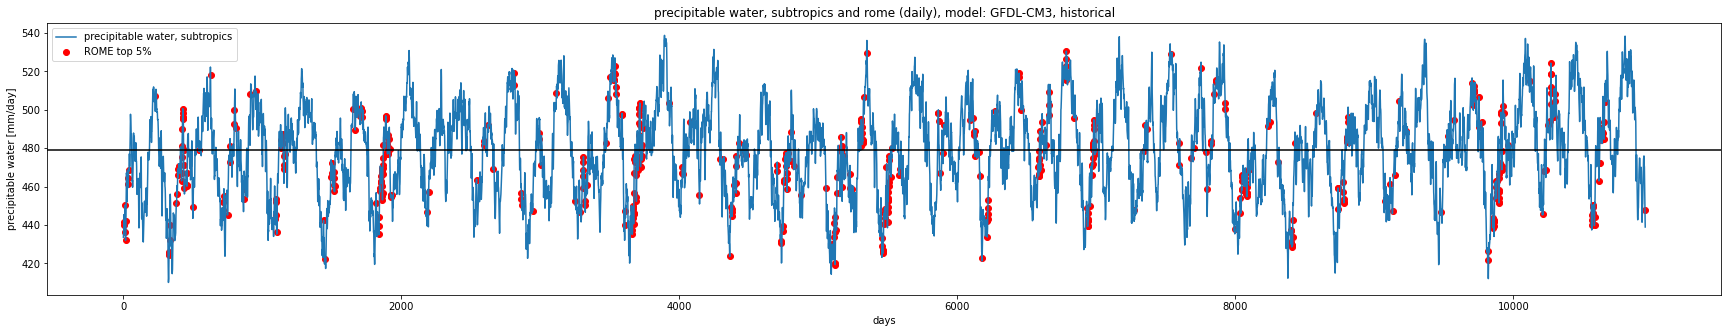

In [37]:
f, ax = plt.subplots(figsize = (30,5))

y = pw_subtropics
x= np.arange(0,len(y),1)
rome_prctile = np.percentile(rome[rome_option],95)
x2= np.argwhere(rome[rome_option].data>=rome_prctile)

ax.plot(x,y, label='precipitable water, subtropics')
ax.scatter(x2,y[x2],label='ROME top 5%', color='r')
ax.axhline(y=np.mean(y), color='k')
ax.set_title('precipitable water, subtropics and ' + rome_option + ' (daily), model: ' + model + ', ' + experiment)
ax.set_xlabel('days')
ax.set_ylabel('precipitable water [mm/day]')
ax.legend()